# Introduction to GradCam Exercises

In [27]:
# Step 1: Install required packages
!pip install -q tensorflow opencv-python matplotlib


In [28]:
# Step 2: Imports
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [29]:
# Step 3: Download and extract dataset manually
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_file = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=False)

# extract manually
extract_path = "/content/cats_and_dogs_filtered"
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("/content/")

In [30]:
# Step 4: Dataset paths
train_dir = os.path.join(extract_path, "train")
val_dir = os.path.join(extract_path, "validation")

In [31]:
# Step 5: Load dataset
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print("class_names:", class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
class_names: ['cats', 'dogs']


In [32]:
# Step 6: Define the model
from tensorflow.keras import Input

# Define CNN using Functional API (instead of Sequential)
inputs = Input(shape=(160, 160, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu', name='last_conv')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Step 7: Train model briefly (2 epochs)
model.fit(train_ds, epochs=2, validation_data=val_ds)

Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.5360 - loss: 0.7101 - val_accuracy: 0.5030 - val_loss: 0.6869
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5536 - loss: 0.6658 - val_accuracy: 0.6430 - val_loss: 0.6273


In [34]:
# Step 8: Pick one test image
for images, labels in val_ds.take(1):
    test_image = images[0:1]
    true_label = labels[0].numpy()
    break

# Call model once to initialize outputs for Grad-CAM
_ = model(test_image)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="last_conv", pred_index=None):

  _ = model(img_array)

  grad_model = tf.keras.models.Model(
      inputs=model.input,
      outputs=[model.get_layer(last_conv_layer_name).output, model.output] # Changed 'output' to 'outputs'
  )

  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(img_array)
      if pred_index is None:
         pred_index = tf.argmax(predictions[0])
      class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()


In [35]:
import numpy as np
import cv2

def superimpose_heatmap(img_array, heatmap, alpha=0.4):
    # 1) Squeeze out any batch/channel dims, scale to [0,255]
    heatmap = np.squeeze(heatmap)
    heatmap = np.uint8(255 * heatmap)

    # 2) Apply JET colormap (returns BGR) → convert to RGB
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    # 3) Prepare original image (uint8 RGB)
    img = img_array
    if img.ndim == 4:            # if batched
        img = img[0]
    if img.dtype != np.uint8:    # if float in [0,1]
        img = np.uint8(255 * img)
    if img.ndim == 2 or img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # 4) Resize heatmap to match image, then blend
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))
    return cv2.addWeighted(jet, alpha, img, 1 - alpha, 0)

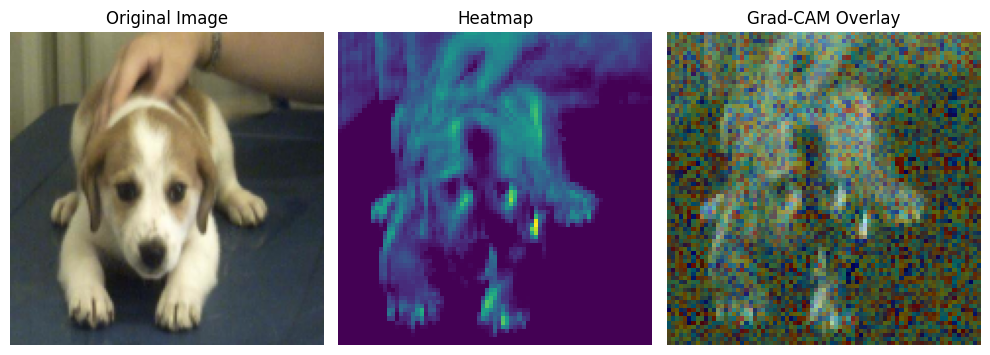

In [36]:
# Step 9: Visualize Grad-CAM
heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer_name="last_conv")
overlay = superimpose_heatmap(heatmap, test_image)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image[0].numpy().astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap="viridis")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

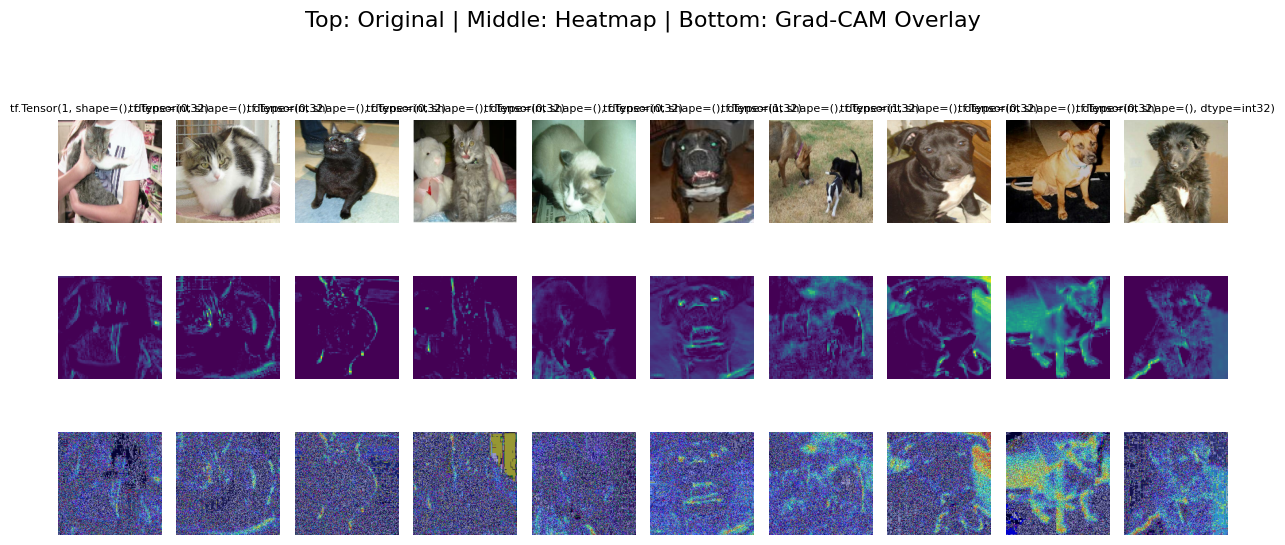

In [37]:
plt.figure(figsize=(12, 6))

for idx, (img, label_text) in enumerate(zip(selected_images, labels)):
    # prepare displayable arrays
    img_disp = img[0].numpy().astype("uint8")
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name="last_conv")
    overlay = superimpose_heatmap(img, heatmap)
    # Row 1: original
    plt.subplot(3, 10, idx + 1)
    plt.imshow(img_disp)
    plt.title(label_text, fontsize=8)
    plt.axis("off")

    # Row 2: heatmap
    plt.subplot(3, 10, 10 + idx + 1)
    plt.imshow(np.squeeze(heatmap), cmap="viridis")
    plt.axis("off")

    # Row 3: overlay
    plt.subplot(3, 10, 20 + idx + 1)
    plt.imshow(overlay)
    plt.axis("off")

plt.suptitle("Top: Original | Middle: Heatmap | Bottom: Grad‑CAM Overlay", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()